In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
# CNN Architecture
input_layer = tf.keras.Input(shape=(32, 32, 3))

conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(input_layer)
conv1 = layers.MaxPooling2D()(conv1)
conv1 = layers.Dropout(0.2)(conv1)

conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.MaxPooling2D()(conv2)
conv2 = layers.Dropout(0.25)(conv2)

conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.MaxPooling2D()(conv3)
conv3 = layers.Dropout(0.3)(conv3)

flattened = layers.Flatten()(conv3)
dense1 = layers.Dense(512, activation='relu')(flattened)
dense1 = layers.BatchNormalization()(dense1)
dense1 = layers.Dropout(0.45)(dense1)

output_layer = layers.Dense(10, activation='softmax')(dense1)

cnn_model = models.Model(inputs=input_layer, outputs=output_layer)

In [4]:
# Compile
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy']
)

In [5]:
# Callbacks
lr_adjust = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Training
history_cnn = cnn_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[lr_adjust, early_stop],
    verbose=1
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.3133 - loss: 2.2480 - val_accuracy: 0.2361 - val_loss: 3.2671 - learning_rate: 5.0000e-04
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5173 - loss: 1.3759 - val_accuracy: 0.5254 - val_loss: 1.4956 - learning_rate: 5.0000e-04
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6101 - loss: 1.1078 - val_accuracy: 0.6451 - val_loss: 1.0469 - learning_rate: 5.0000e-04
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6593 - loss: 0.9680 - val_accuracy: 0.6663 - val_loss: 0.9618 - learning_rate: 5.0000e-04
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6958 - loss: 0.8614 - val_accuracy: 0.6902 - val_loss: 0.8757 - learning_rate: 5.0000e-04
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7129 - loss: 0.8077 - val_accuracy: 0.7158 - val_loss: 0.8036 - learning_rate: 5.0000e-04
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accurac

In [6]:
# Evaluation
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Custom CNN Test Accuracy: {test_acc_cnn:.4f}")

Custom CNN Test Accuracy: 0.8183


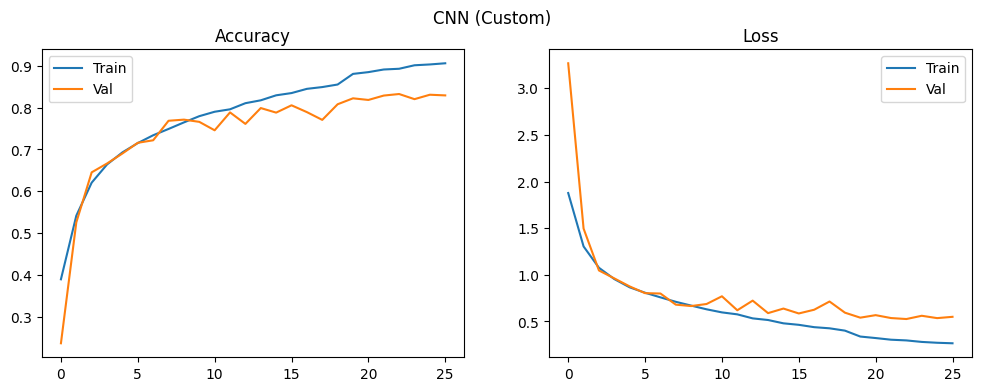

In [7]:
def plot_training(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.suptitle(model_name)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_training(history_cnn, "CNN (Custom)")


In [8]:
# Reload and preprocess
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [9]:
# Load base model
resnet_base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet"
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
# Freeze layers
for layer in resnet_base.layers[:143]:
    layer.trainable = False

In [11]:
# Build Transfer Model
resnet_model = models.Sequential([
    layers.Lambda(lambda img: tf.image.resize(img, (224, 224))),
    resnet_base,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='swish'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='swish'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='swish'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

In [12]:
# Compile
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['accuracy']
)

In [13]:
# Callbacks
lr_decay = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, min_lr=1e-6, verbose=1)
early_stop_tl = callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)


In [14]:
# Training
history_resnet = resnet_model.fit(
    x_train, y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[early_stop_tl, lr_decay],
    verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 301ms/step - accuracy: 0.6033 - loss: 1.2568 - val_accuracy: 0.9070 - val_loss: 0.3155 - learning_rate: 2.0000e-05
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 242s 297ms/step - accuracy: 0.9066 - loss: 0.3852 - val_accuracy: 0.9290 - val_loss: 0.2446 - learning_rate: 2.0000e-05
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 297ms/step - accuracy: 0.9491 - loss: 0.2268 - val_accuracy: 0.9373 - val_loss: 0.2118 - learning_rate: 2.0000e-05
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 296ms/step - accuracy: 0.9743 - loss: 0.1396 - val_accuracy: 0.9403 - val_loss: 0.2053 - learning_rate: 2.0000e-05
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 296ms/step - accuracy: 0.9855 - loss: 0.0896 - val_accuracy: 0.9417 - val_loss: 0.2018 - learning_rate: 2.0000e-05
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9930 - loss: 0.0566
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 29

ResNet50 Transfer Learning Test Accuracy: 0.9437


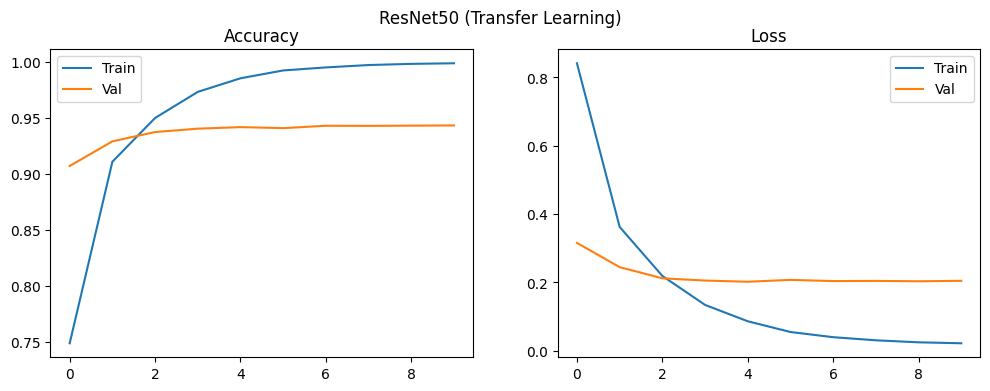

In [15]:
# Evaluation
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(x_test, y_test, verbose=0)
print(f"ResNet50 Transfer Learning Test Accuracy: {test_acc_resnet:.4f}")

plot_training(history_resnet, "ResNet50 (Transfer Learning)")


###  **Summary & Conclusion**


* **Dataset Used**: CIFAR-10, containing 60,000 32x32 RGB images in 10 classes.
* Two different approaches were implemented and compared for image classification:

  1. **CNN from Scratch**: A custom convolutional neural network designed and trained from the ground up.
  2. **Transfer Learning with ResNet50**: A pre-trained ResNet50 model (on ImageNet), fine-tuned for CIFAR-10 classification.

####  CNN From Scratch:

* Built with multiple convolutional layers, max-pooling, dropout, and batch normalization.
* Trained entirely on CIFAR-10 from random weight initialization.
* Implemented early stopping and learning rate reduction to prevent overfitting.

####  Transfer Learning with ResNet50:

* Used pre-trained ResNet50 (excluding top layers).
* Added custom classification layers on top.
* Majority of ResNet layers were frozen; only top layers were fine-tuned.
* Used image resizing to 224x224 for ResNet input compatibility.

###  **Conclusion:**

* ResNet50 outperforms the custom CNN by a significant margin in all accuracy metrics.
* The custom CNN, while decent, suffers from lower generalization due to its simpler architecture and lack of learned features from large-scale datasets.
* Transfer learning with ResNet50 benefits from deep feature hierarchies and pre-trained weights, making it more effective and accurate, especially with limited data or fewer epochs.
* Key difference: ResNet50 uses residual connections that help train deeper models without vanishing gradients, whereas the custom CNN lacks such depth and architectural enhancements.